# Hand-Written shapes classification using DeepLearning (PyTorch)

#### Importing libraries

`pandas` for playing with .csv

`numpy` for dealing with images

`torch.nn` for defining neural network

`torch.nn.functional`

`torch.optim`

`torchvision.transforms` for defining transforms

`torch.utils.data.Dataloader` for creating dataloader

`matplotlib.pyplot` for plotting images/graphs


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch import optim
from torchvision.transforms import transforms
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data import random_split 
import matplotlib.pyplot as plt
import random

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


## Load dataset
Loading the dataset for training+validating and for testing
then splitting them into images and labels

In [3]:
df_fullDataset = pd.read_csv('../input/mnistlike-dataset-squarecircletriangle/train_data.csv')
df_fullDataset

,label,P1,P2,P3,P4,P5,P6,P7,P8,P9,...,P775,P776,P777,P778,P779,P780,P781,P782,P783,P784
0,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,0,254,255,255,254,255,255,255,255,0,...,255,255,255,255,255,255,255,255,255,255
2,0,255,254,255,255,254,255,253,255,254,...,254,255,254,255,255,255,255,255,255,255
3,0,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,0,255,255,255,255,255,255,255,255,253,...,255,255,255,255,255,255,255,255,255,255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
196,1,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
197,1,255,255,255,255,255,255,255,255,254,...,255,255,255,255,255,255,255,255,255,255
198,1,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


### Get the image pixel values and labels

In [4]:
fullDataset_images = df_fullDataset.iloc[:, 1:]
fullDataset_labels = df_fullDataset.iloc[:, 0]

### Transforms
Defining image transforms. Using `Compose` we chain different transforms.

Here we transform image csv data to PIL image, then to Tensor, and then they are normalized. 

Tensor images with a float dtype are expected to have values in `[0,1)`.

`Normalize` does the following for each channel:

`image = (image - mean) / std`
The parameters for Normalize are `(mean, std)`

The parameters mean, std are passed as 0.5, 0.5. This will normalize the image in the range `[-1,1]`. For example, the minimum value 0 will be converted to (0-0.5)/0.5=-1, the maximum value of 1 will be converted to (1-0.5)/0.5=1.

In [5]:
transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, ), (0.5, ))
])

### Custom Dataset
Defining custom dataset. 
We create a class with three functions. `__init__` initializes, `__len__` is returns the length of dataset, `__getitem__` returns specific data.

In [6]:
class ShapesDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :]
        data = np.asarray(data).astype(np.uint8).reshape(28, 28, 1)
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

In [7]:
full_data = ShapesDataset(fullDataset_images, fullDataset_labels, transform)

### Plotting the Dataset

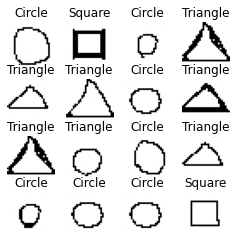

In [8]:
labels_map = {
    0: "Circle",
    1: "Triangle",
    2: "Square",
}
figure = plt.figure(figsize=(4, 4))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(full_data), size=(1,)).item()
    img, label = full_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### Splitting the Full Dataset
Splitting using the `random_split` function(takes in the full ds and sizes) from torch.utils.data

In [9]:
train_size = int(0.7*len(full_data))
val_size = len(full_data) - train_size

train_data, val_data = random_split(full_data,[train_size,val_size])

### Dataloader
While training a model, we typically want to pass samples in _“minibatches”_, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval.

Dataloader is an iterable that does this

In [10]:
trainloader = DataLoader(train_data, batch_size=10, shuffle=True)
valloader = DataLoader(val_data, batch_size=10, shuffle=True)

## Building and Training the Model
### Defining the NN
We initialize the NN in the `__init__` method, and operations are implemented on the input data in the `forward` method.

`nn.flatten` converts each 2D 28x28 imaage into continous array of 784 pixel values.

`nn.Linear` applies a linear transformation on the input using its stored weights and biases.

Non-linear activations are what create the complex mappings between the model’s inputs and outputs. They are applied after linear transformations to introduce nonlinearity, helping neural networks learn a wide variety of phenomena. There are many functions/activations, but here we use `nnReLU`

`nn.Sequential` is an ordered container of modules/fns. 

In [11]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 3)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

We create an instance of `NeuralNetwork` and move it to device.

In [12]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)


## Optimization Loop
We train and optimize our model using the Optimization loop, whose each iteration is called an **epoch**. Each epoch has two main parts:
1. **Train Loop** - Iterate over training dataset
2. **Validation Loop** - Iterate over validation dataset to check if model performance is improving.

### Loss Function
Loss function measures the degree of dissimilarity of obtained result to the target value, and we want to minimize this during training.
To calculate the loss we make a prediction using the inputs of our given date and compare it against the true data label value.

Here we use `nn.CrossEntropyLoss` (combination of `nn.LogSoftmax` and `nn.NLLLoss`).

In [13]:
loss_fn = nn.CrossEntropyLoss()

### Optimizer
Optimzation is the process of adjusting model parameters in each training step, to reduce model error. 

Different Optimization algorithms define how this process is performed. Here we use `SGD` optimizer, i.e. **Stochastic Gradient Descent**. We also pass in the *Learning rate* as the second parameter.

In [14]:
optimizer = optim.SGD(model.parameters(), lr=1e-3)

In [15]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()  #resets the gradient of model parameter, otherwise they'll add up in each iteration
        loss.backward()   #PyTorch deposits the gradients of the loss w.r.t. each parameter
        optimizer.step()   #adjusts the parameters by the gradients collected in the backward pass

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [16]:
def val(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [17]:
epochs = 100
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(trainloader, model, loss_fn, optimizer)
    val(valloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 1.106827  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.084811 

Epoch 2
-------------------------------
loss: 1.061358  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.067237 

Epoch 3
-------------------------------
loss: 1.048741  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.050747 

Epoch 4
-------------------------------
loss: 1.062198  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.035249 

Epoch 5
-------------------------------
loss: 1.010120  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.020594 

Epoch 6
-------------------------------
loss: 1.019774  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 1.006494 

Epoch 7
-------------------------------
loss: 0.965433  [    0/  140]
Test Error: 
 Accuracy: 56.7%, Avg loss: 0.992823 

Epoch 8
-------------------------------
loss: 0.975169  [    0/  140]
Test Error: 
 Accuracy: 63.3%, Avg loss: 0.979320 

Epoch 9
----------------

### Saving the model

In [18]:
torch.save(model.state_dict(), "./model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


## Testing the Model
### Loading the model

In [19]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

In [20]:
classes = [
    "Circle",
    "Triangle",
    "Square",
]

model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [21]:
for i in range(10):
    rand_idx = random.randint(0,len(val_data)-1)
    x, y = val_data[rand_idx][0], val_data[rand_idx][1]

    with torch.no_grad():
        pred = model(x)
        predicted, actual = classes[pred[0].argmax(0)], classes[y]
        print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "Triangle", Actual: "Circle"
Predicted: "Square", Actual: "Square"
Predicted: "Circle", Actual: "Circle"
Predicted: "Triangle", Actual: "Triangle"
Predicted: "Circle", Actual: "Circle"
Predicted: "Triangle", Actual: "Triangle"
Predicted: "Triangle", Actual: "Triangle"
Predicted: "Square", Actual: "Square"
Predicted: "Square", Actual: "Square"
Predicted: "Triangle", Actual: "Triangle"
